## Basis

In [ ]:
# load map of genes to cytosig signatures
cytosig_map = pd.read_csv('../cytosig_map.csv', index_col=0)
cytosig_map = cytosig_map.reset_index(names='source')
# Translate targets
cytosig_map = dc.translate_net(cytosig_map, target_organism = 'mouse', columns=['target'])
cytosig_map.head()

## Run MOFAcell

In [ ]:
from mudata import MuData
import muon as mu
import mofax as mofa

In [ ]:
adata = sc.concat(adatas=adatas)
adata.obs['leiden'] = adata.obs['leiden'].replace({'5':'2'})

In [ ]:
mdata = li.multi.adata_to_views(adata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=None,
                                min_prop=0.05, # min nnz values (filter features]
                                min_smpls=3, # min samples per view (filter features]
                                min_cells=25, # min cells per view (filter samples]
                                min_counts=100, # min counts per view (filter samples]
                                mode='sum', # mode of aggregation
                                verbose=True,
                                skip_checks=True,
                                layer='counts'
                                )

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


In [ ]:
for mod in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[mod], target_sum=1e4)
    sc.pp.log1p(mdata.mod[mod])
    
    sc.pp.highly_variable_genes(mdata.mod[mod], min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/mofacell.hdf5",
                   n_factors=4,
                   use_var='highly_variable'
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=7741 features...
Loaded view='1' group='group1' with N=5 samples and D=9674 features...
Loaded view='3' group='group1' with N=5 samples and D=10690 features...
Loaded view='2' group='group1' with N=5 samples and D=10097 features...
Loaded view='0' group='group1' with N=5 samples and D=8821 features...


Model options:
- Autom

In [ ]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head(]

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3900559239.py, line 3)

In [ ]:
model = mofa.mofa_model("models/mofacell.hdf5")
model

In [ ]:
mofa.plot_r2(model, x='View')

In [ ]:
model.close()

## Run MOFAtalk

In [ ]:
lrdata.obs['group'] = lrdata.obs['sample'].str.split('_').str[0]

In [ ]:
mdata = li.multi.adata_to_views(lrdata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=['group'],
                                min_prop=0.05, # min nnz values (filter features]
                                min_smpls=3, # min samples per view (filter features]
                                min_cells=25, # min cells per view (filter samples]
                                min_counts=0, # min counts per view (filter samples]
                                mode='mean', # mode of aggregation
                                verbose=True,
                                skip_checks=True
                                )

100%|██████████| 6/6 [00:00<00:00, 43.29it/s]


In [ ]:
mdata

MuData object with n_obs × n_vars = 1 × 4917
  obs:	'group'
  6 modalities
    4:	1 x 799
      layers:	'psbulk_props'
    1:	1 x 817
      layers:	'psbulk_props'
    3:	1 x 840
      layers:	'psbulk_props'
    2:	1 x 835
      layers:	'psbulk_props'
    0:	1 x 807
      layers:	'psbulk_props'
    5:	1 x 819
      layers:	'psbulk_props'

In [ ]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/lrs.h5ad",
                   n_factors=4
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=1 samples and D=799 features...
Loaded view='1' group='group1' with N=1 samples and D=817 features...
Loaded view='3' group='group1' with N=1 samples and D=840 features...
Loaded view='2' group='group1' with N=1 samples and D=835 features...
Loaded view='0' group='group1' with N=1 samples and D=807 features...
Loaded view='5' group='group1' 

ValueError: n_components=4 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [ ]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()


ValueError: X_mofa not found in mdata.obsm

In [ ]:
model = mofa.mofa_model("models/lrs.h5ad")
model

MOFA+ model: lrs.h5ad
Samples (cells): 5
Features: 3071
Groups: group1 (5)
Views: 0 (542), 1 (540), 2 (553), 3 (550), 4 (425), 5 (461)
Factors: 5
Expectations: W, Z

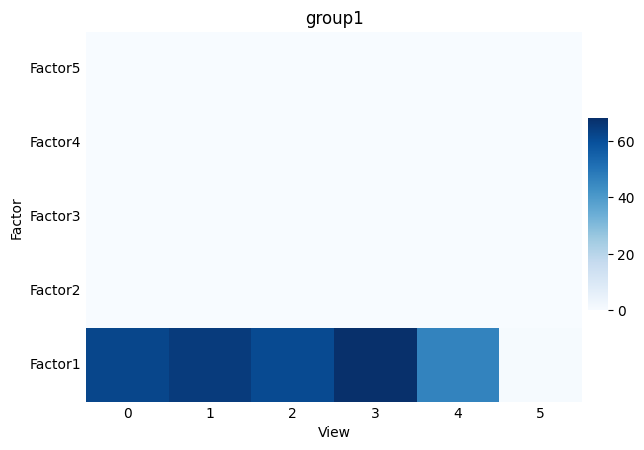

In [ ]:
mofa.plot_r2(model, x='View')

In [ ]:
factor1_loadings =  li.multi.get_variable_loadings(mdata, 0, view_separator=':') # get loadings for factor 1
## NOTE this should work, not only with 0...

KeyError: 'LFs'

In [ ]:
factor1_loadings.head(10)

NameError: name 'factor1_loadings' is not defined